In [64]:
import networkx as nx
import numpy as np
import pandas as pd

def create_network(df):
   """
   Converts a DataFrame with source nodes, target nodes and edge weights
   into a directed NetworkX graph.

   Parameters:
   ----------
   df : pandas.DataFrame
       A DataFrame with the following columns:
       - 'source': Source node (str or int)
       - 'target': Target node (str or int)
       - 'weight': Weight of the directed edge (int or float)

   Returns:
   -------
   G : networkx.DiGraph
       A directed graph where each edge from 'source' to 'target' has an associated weight.
   """
   
   G = nx.DiGraph() # Initialize a directed graph

   # Iterate through each row to add edges with weights
   for _, row in df.iterrows():
       source = row['source']
       target = row['target']
       weight = row['weight']
       G.add_edge(source, target, weight=weight)

   return G

#Generate random dataframe to check the code:
df = pd.DataFrame({
    'source': np.random.randint(0, 500, size=1000),
    'target': np.random.randint(0, 500, size=1000),
    'weight': np.random.rand(1000)
})

#Built in networkx
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph(), edge_key=None)

#function check:
G = create_network(df) #quick enough

In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [66]:
def collect_paths(G, source, target, num_paths=10, max_steps=100):
    """
    Perform random walks on a directed weighted graph from source to target.

    Parameters:
    ----------
    G : networkx.DiGraph
        A directed graph with edge weights used as transition probabilities.
    source : node
        Starting node for the random walk.
    target : node
        Ending node to stop the walk.
    num_paths : int
        Number of random walk paths to collect (default = 1000).
    max_steps : int
        Maximum steps per walk to avoid infinite loops (default = 100).

    Returns:
    -------
    paths : list of lists
        A list containing up to `num_paths` paths (each a list of nodes) from source to target.
    """
    paths = []

    for _ in range(num_paths):
        
        path = [source]
        current = source
        steps = 0

        while current != target and steps < max_steps:
            neighbors = list(G.successors(current))
            if not neighbors:
                break  # dead end
            probabilities = [G[current][nbr].get('weight', 1.0) for nbr in neighbors]
            current = random.choices(neighbors, weights=probabilities, k=1)[0]
            path.append(current)
            steps += 1

        if path[-1] == target:
            paths.append(path)

    return paths

paths = dict()
from tqdm import tqdm
for source in G.nodes():
    for target in G.nodes():
        if target!=source:
            paths[(source,target)] =  collect_paths(G, source, target, num_paths=10, max_steps=100)
        

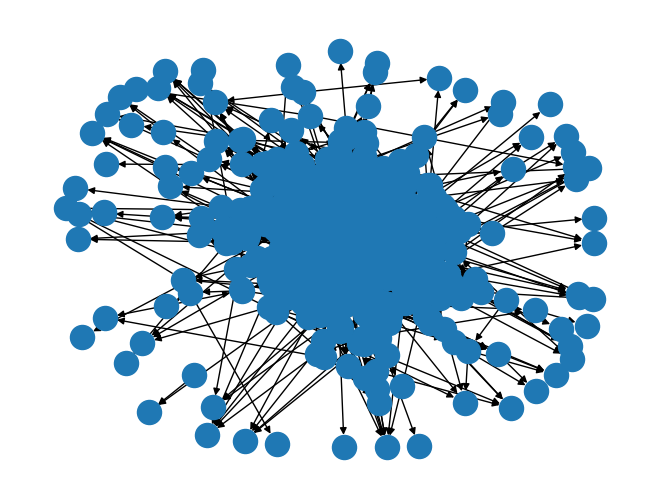

In [34]:
nx.draw(G)


In [36]:
import numpy as np
import random
from itertools import zip_longest
import sys


if len(sys.argv) < 5:
    print("Usage: %s <edges> <prop> <num> <idx> \n" % sys.argv[0])
    exit(1)


def compute_neighbours(edges):
    # dictionary with node neighbours
    E = dict()
    for i, j in edges:
        if i in E:
            E[i].append(j)
        else:
            E[i] = [j]
    return E


def fill_empty_classes(i, idxs):
    # find groups not represented in city, update w/ 1
    obs = classes[i]
    for n in idxs:
        # set group count to 1
        obs[n] = 1
    return obs


def walk(i, obs):
    nc = []  # number of classes seen
    while 0 in obs:
        # selects one of i neighbours
        j = random.choice(neigh_dict[i])
        obs = obs + classes[j]
        # get current number of classes seen
        non_z = int(np.count_nonzero(obs) - len(idxs))
        nc.append(non_z)
        i = j
    return nc

# %%
# initialize dict with neighbours
neigh_dict = compute_neighbours(np.loadtxt(sys.argv[1], dtype='int'))

# load population data and set variables
prop = np.loadtxt(sys.argv[2], dtype='int')
classes = prop[:, 1:]

# total of class at city level
classes_sum = classes.sum(axis=0)
# total number of classes in the system
C = (classes_sum >= 1).sum()

# index of missing groups at city level
idxs = np.where(classes_sum == 0)[0]

# process range or single node from param
if "-" in sys.argv[4]:
    start, end = [int(x) for x in sys.argv[4].split('-')]
else:
    start, end = [int(sys.argv[4]), int(sys.argv[4])+1]
num = int(sys.argv[3])


# loop over all nodes given on input
for node in range(start, end):
    # fill empty classes
    if len(idxs) > 0:
        obs = fill_empty_classes(node, idxs)
    else:
        obs = classes[node]
    avg_series = []
    # repeat "num" iterations for each node
    for n in range(num):
        series = walk(node, obs)
        # check if is first trajectory
        if len(avg_series) == 0:
            avg_series = series
            continue
        len_avg = len(avg_series)
        len_sr = len(series)
        # concatenate series with avg and fill missing values
        if len_avg < len_sr:
            summed = [sum(x) for x in zip_longest(avg_series, series, fillvalue=C*n)]
        elif len_avg > len_sr:
            summed = [sum(x) for x in zip_longest(avg_series, series, fillvalue=C)]
        else:
            summed = [sum(x) for x in zip(avg_series, series)]
        # update avg_series with trajectories summed
        avg_series = summed

    # compute avg over all trajectories
    avg_series = [nc/num for nc in avg_series]

    # compute the avg time to find each ratio of classes in [0,1]
    th_values = []
    for t in range(1, 101):
        # th = int(np.ceil((t*C)/100))
        th = (t*C) // 100  # threshold value
        time = 0
        # check only series w/ first elem > th
        for s in avg_series:
            if s >= th:
                time += 1
                break
            else:
                time += 1
        # time for each th per node (series)
        th_values.append(time)
    # dump node id and class coverage profile (time for each fraction)
    print(node, *th_values)

Usage: /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py <edges> <prop> <num> <idx> 



FileNotFoundError: -f not found.

In [44]:
G.number_of_edges()/(G.number_of_nodes())*(G.number_of_nodes()-1)


995.9507186858316

In [52]:
g=G.number_of_nodes()

In [78]:
import networkx as nx
import random
from tqdm import tqdm

def collect_paths(G, source, target, num_paths=1000, max_steps=100, random_seed=None):
    """
    Perform weighted random walks from source to target on a directed graph.

    Parameters:
    ----------
    G : networkx.DiGraph
        A directed graph with edge weights.
    source : node
        Start node.
    target : node
        Target node to stop the walk.
    num_paths : int
        Number of paths to collect.
    max_steps : int
        Max steps per walk to avoid infinite loops.
    random_seed : int or None
        Optional seed for reproducibility.

    Returns:
    -------
    paths : list of lists
        A list of successful paths from source to target.
    """
    if random_seed is not None:
        rng = random.Random(random_seed)
    else:
        rng = random

    paths = []

    for _ in range(num_paths):
        path = [source]
        current = source
        steps = 0

        while current != target and steps < max_steps:
            neighbors = list(G.successors(current))
            if not neighbors:
                break  # Dead end
            weights = [G[current][nbr].get('weight', 1.0) for nbr in neighbors]
            current = rng.choices(neighbors, weights=weights, k=1)[0]
            path.append(current)
            steps += 1

        if path[-1] == target:
            paths.append(path)

    return paths


# Collect all-to-all paths efficiently
paths = dict()
for source in tqdm(G.nodes(), desc="Processing sources"):
    for target in G.nodes():
        if source != target and nx.has_path(G, source, target):
            paths[(source, target)] = collect_paths(G, source, target, num_paths=1000, max_steps=100)


Processing sources: 100%|█████████████████████| 493/493 [19:02<00:00,  2.32s/it]


In [ ]:
import networkx as nx
import random
from tqdm import tqdm

def precompute_transitions(G):
    """
    Precompute neighbor lists and edge weights for all nodes in the graph.
    Returns a dictionary: node -> (neighbors, weights)
    """
    transitions = {}
    for node in G.nodes():
        neighbors = list(G._succ[node])
        if neighbors:
            weights = [G[node][nbr].get('weight', 1.0) for nbr in neighbors]
            transitions[node] = (neighbors, weights)
    return transitions

def collect_paths(G, source, target, transitions, max_steps=100, random_seed=None):
    """
    Perform random walks from source to target using precomputed transitions.

    Parameters:
    -----------
    G : networkx.DiGraph
    source : node
    target : node
    transitions : dict
        Precomputed neighbors and weights per node.
    num_paths : int
    max_steps : int
    random_seed : int or None

    Returns:
    --------
    paths : list of list of nodes
    """
    rng = random.Random(random_seed)
    paths = []
    num_paths=0
    
    while(num_paths!=100):
        path = [source]
        current = source
        steps = 0

        while current != target and steps < max_steps:
            if current not in transitions:
                break  # dead end
            neighbors, weights = transitions[current]
            current = rng.choices(neighbors, weights=weights, k=1)[0]
            path.append(current)
            steps+= 1 

        if path[-1] == target:
            paths.append(path)
            num_paths+= 1

    return paths



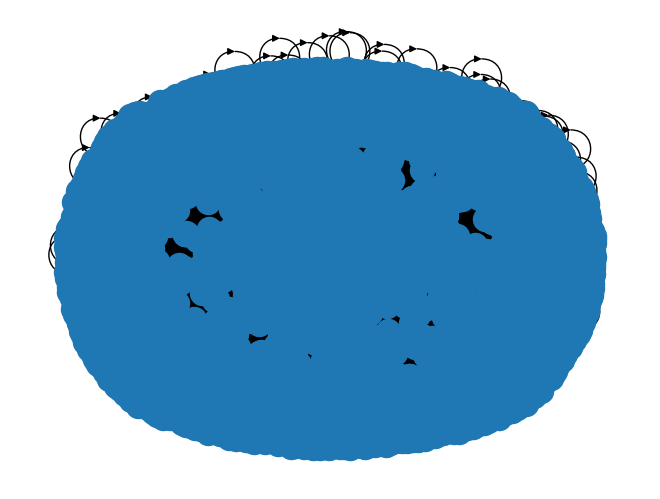

In [96]:
file_path = '/Users/devanshsharma/Downloads/Weighted_network_data.csv' 
df = pd.read_csv(file_path)

df.head()

G = nx.DiGraph()

# Add weighted edges
for _, row in df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    num_people = row['number_people']

    # Add edge with weight and optional attributes
    G.add_edge(source, target, weight=weight, number_people=num_people)




In [98]:
G.number_of_nodes()

6195

In [100]:
G.number_of_edges()

9747

In [158]:
transitions = precompute_transitions(G)

paths = {}
for source in tqdm(G.nodes(), desc="Processing sources"):
    for target in G.nodes():
        if source != target and nx.has_path(G, source, target):  # Optional: skip if unreachable
            paths[(source, target)] = collect_paths(
                G, source, target, transitions, num_paths=100, max_steps=100
            )

Processing sources: 100%|███████████████████| 6195/6195 [01:29<00:00, 69.00it/s]


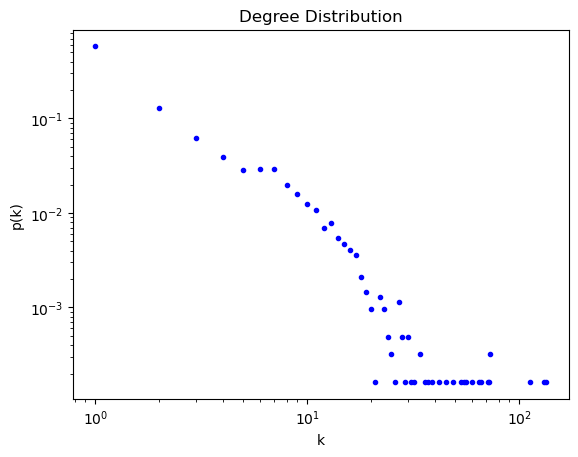

In [122]:
import matplotlib.pyplot as plt
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    plt.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.')
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title('Degree Distribution')
    plt.show()

plot_degree_dist(G)

In [128]:
degree_hist = nx.degree_histogram(G,bins=50) 
plt.hist(degree_hist)

TypeError: degree_histogram() got an unexpected keyword argument 'bins'

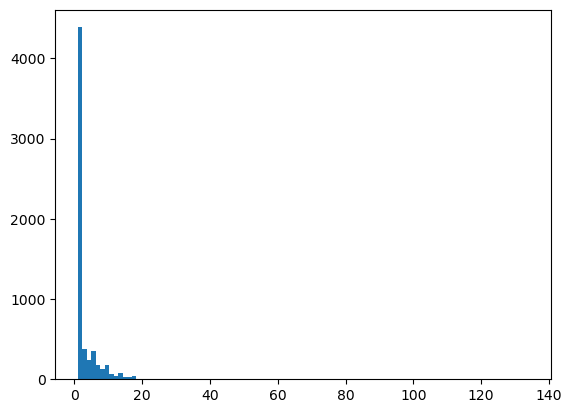

134

In [162]:
G.to_undirected()
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees,bins=100)
plt.show()
max(degrees)

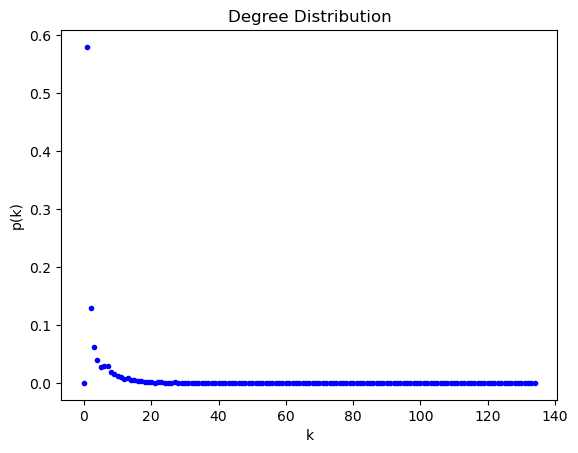

In [166]:
degree_hist = nx.degree_histogram(G) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/G.number_of_nodes()
plt.plot(np.arange(degree_prob.shape[0]),degree_prob,'b.')


plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Degree Distribution')
plt.show()

In [170]:
disconnected_edges = []
for component in nx.weakly_connected_components(G):  # for directed graph G
    subgraph = G.subgraph(component)
    if subgraph.number_of_nodes() == 2 and subgraph.number_of_edges() == 1:
        disconnected_edges.extend(subgraph.edges())

#len(disconnected_edges) #266 

largest_cc_nodes = max(nx.weakly_connected_components(G)) #5165 nodes
largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy()

In [208]:
# pos = nx.circular_layout(G)

# colors = [G[u][v]['color'] for u,v in edges]
weights = [largest_cc_subgraph[u][v]['weight'] for u,v in edges]

# nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)

nx.draw(largest_cc_subgraph, weights)

pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)

NameError: name 'edges' is not defined

In [184]:
transitions = precompute_transitions(largest_cc_subgraph)

paths = {}
for source in tqdm(largest_cc_subgraph.nodes(), desc="Processing sources"):
    for target in largest_cc_subgraph.nodes():
        if source != target and nx.has_path(largest_cc_subgraph, source, target):  # Optional: skip if unreachable
            paths[(source, target)] = collect_paths(
                largest_cc_subgraph, source, target, transitions, num_paths=100, max_steps=100
            )

Processing sources:   0%|                  | 19/5196 [03:29<15:49:11, 11.00s/it]


KeyboardInterrupt: 

In [200]:
import networkx as nx
import random
from tqdm import tqdm

def precompute_transitions(G):
    """
    Precompute neighbor lists and edge weights for all nodes in the graph.
    Returns a dictionary: node -> (neighbors, weights)
    """
    transitions = {}
    for node in G.nodes():
        neighbors = list(G._succ[node])
        if neighbors:
            weights = [G[node][nbr].get('weight', 1.0) for nbr in neighbors]
            transitions[node] = (neighbors, weights)
    return transitions

def collect_paths(G, source, target, transitions, max_steps=1000, random_seed=None):
    """
    Perform random walks from source to target using precomputed transitions.

    Parameters:
    -----------
    G : networkx.DiGraph
    source : node
    target : node
    transitions : dict
        Precomputed neighbors and weights per node.
    num_paths : int
    max_steps : int
    random_seed : int or None

    Returns:
    --------
    paths : list of list of nodes
    """
    rng = random.Random(random_seed)
    paths = []
    num_paths=0
    
    while(num_paths!=100):
        path = [source]
        current = source
        steps = 0

        while current != target and steps < max_steps:
            if current not in transitions:
                break  # dead end
            neighbors, weights = transitions[current]
            current = rng.choices(neighbors, weights=weights, k=1)[0]
            path.append(current)
            steps+= 1 

        if path[-1] == target:
            paths.append(path)
            num_paths+= 1

    return paths



In [202]:
transitions = precompute_transitions(largest_cc_subgraph)

paths = {}
for source in tqdm(largest_cc_subgraph.nodes(), desc="Processing sources"):
    for target in largest_cc_subgraph.nodes():
        if source != target and nx.has_path(largest_cc_subgraph, source, target):  # Optional: skip if unreachable
            paths[(source, target)] = collect_paths(
                largest_cc_subgraph, source, target, transitions, max_steps=1000
            )

Processing sources:   0%|                  | 20/5196 [18:10<78:22:19, 54.51s/it]


KeyboardInterrupt: 

In [210]:
nx.number_of_selfloops(largest_cc_subgraph)

74

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

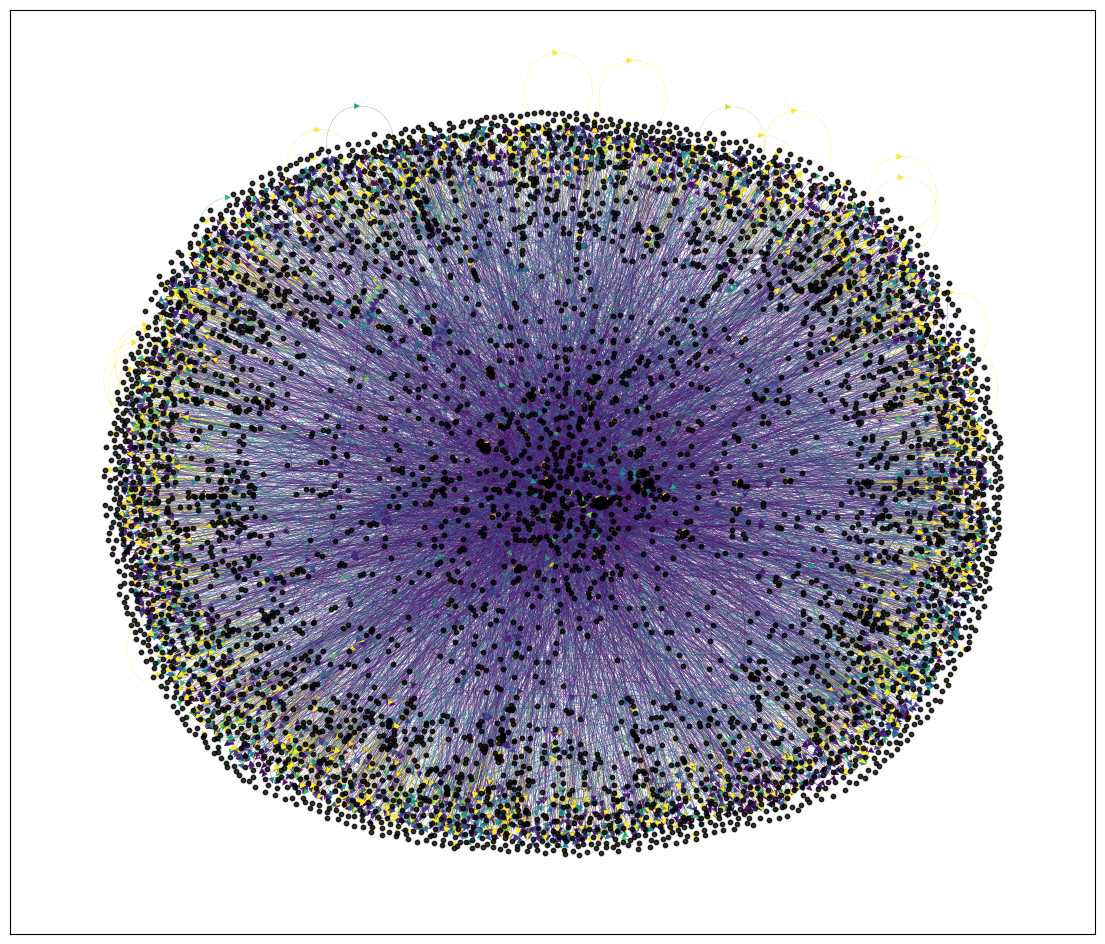

In [226]:
def visualize_weighted_network(G, weight_attr='weight', edge_cmap=plt.cm.viridis, min_weight=None, max_weight=None, figsize=(14, 12)):
    """
    Visualize a directed graph with edge color based on weights.

    Parameters:
    -----------
    G : networkx.DiGraph
        The directed graph to visualize.
    weight_attr : str
        The edge attribute representing the weight.
    edge_cmap : colormap
        Matplotlib colormap to use for edge coloring.
    min_weight : float or None
        Minimum edge weight for color normalization (optional).
    max_weight : float or None
        Maximum edge weight for color normalization (optional).
    figsize : tuple
        Size of the figure.
    """
    pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(G.number_of_nodes()))

    # Extract edges and weights
    edges = list(G.edges())
    weights = np.array([G[u][v].get(weight_attr, 1.0) for u, v in edges])

    # Normalize weights for color mapping
    min_w = weights.min() if min_weight is None else min_weight
    max_w = weights.max() if max_weight is None else max_weight
    norm_weights = (weights - min_w) / (max_w - min_w + 1e-9)
    edge_colors = edge_cmap(norm_weights)

    # Plot
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='black', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, arrows=True, arrowstyle='-|>', width=0.2)

    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=min_w, vmax=max_w))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Edge Weight', rotation=270, labelpad=15)

    plt.axis('off')
    plt.title("Weighted Directed Network")
    plt.show()

visualize_weighted_network(largest_cc_subgraph, weight_attr='weight', edge_cmap=plt.cm.viridis, min_weight=None, max_weight=None, figsize=(14, 12))
